# Comp Vis 2

## U1-  Lecture/Lab 3:  Tracking

David Olivieri
Universidad de Vigo


In this notebook, many of the ideas from the lecture are implemented in OpenCV. Some suggested exercises are provided to test your knowledge and explore further. 

##  What is tracking?



### Simply put, locating an object in successive frames of a video is called tracking.


Tracking can be defined as the problem of estimating the trajectory of an object in the image plane as it moves around the scene. In other words a tracker assigns consistent labels to the tracked objects in different frames of a video. Although this sounds like a trivial task, tracking objects in a video sequence can be complex. The difficulty can arise due to rapid appearance change caused by image noise, illumination, non rigid body motions, or because of non stable backgrounds, occlusions and interaction between multiple objects. Loss of information caused by projection from 3D world to a 2D image is also a challenge while solving this problem.



###  Brief (simple) list of type of trackers

All the following different but related ideas are generally studied under Object Tracking:

- **Dense Optical flow:** These algorithms help estimate the motion vector of every pixel in a video frame.
- **Sparse optical flow:** These algorithms, like the Kanade-Lucas-Tomashi (KLT) feature tracker, track the location of a few feature points in an image.
- **Kalman Filtering:** A very popular signal processing algorithm used to predict the location of a moving object based on prior motion information. One of the early applications of this algorithm was missile guidance! Also as mentioned here, “the on-board computer that guided the descent of the Apollo 11 lunar module to the moon had a Kalman filter”.
- **Meanshift and Camshift:** These are algorithms for locating the maxima of a density function. They are also used for tracking.
- **Single object trackers:** In this class of trackers, the first frame is marked using a rectangle to indicate the location of the object we want to track. The object is then tracked in subsequent frames using the tracking algorithm. In most real-life applications, these trackers are used in conjunction with an object detector.
- **Multiple object tracking with Re-Identification:** In cases when we have a fast object detector, it makes sense to detect multiple objects in each frame and then run a track finding algorithm that identifies which rectangle in one frame corresponds to a rectangle in the next frame.

# 1. Comparing Meanshift and Camshift

As we saw, the Meanshift and Camshift are quite similar.  They are based upon moving window estimates of the mean.  They require that we position a point however. 

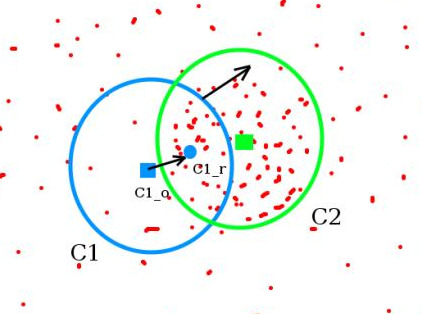

## 1.A  Meanshift code.

Notice, it uses a histogram window. 

To use meanshift in OpenCV, first we need to setup the target, find its histogram so that we can backproject the target on each frame for calculation of meanshift. We also need to provide an initial location of window. For histogram, only Hue is considered here. Also, to avoid false values due to low light, low light values are discarded using cv.inRange() function.

In [ ]:
import numpy as np
import cv2 as cv
import argparse

cap = cv.VideoCapture('./videos/slow_traffic_small.mp4')
# take first frame of the video
ret,frame = cap.read()
# setup initial location of window
x, y, w, h = 300, 200, 100, 50 # simply hardcoded the values
track_window = (x, y, w, h)
# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    ret, frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply meanshift to get the new location
        ret, track_window = cv.meanShift(dst, track_window, term_crit)
        # Draw it on image
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv.imshow('img2',img2)
        
        k = cv.waitKey(30) & 0xff    #ESC  pressed
        if k == 27:
            break
    else:
        break
        
cv.destroyAllWindows()
cap.release()

## 1.B Camshift

Did you closely watch the last result? There is a problem. Our window always has the same size whether the car is very far or very close to the camera. That is not good. We need to adapt the window size with size and rotation of the target. Once again, the solution came from "OpenCV Labs" and it is called CAMshift (Continuously Adaptive Meanshift) published by Gary Bradsky in his paper "Computer Vision Face Tracking for Use in a Perceptual User Interface" in 1998 [35] .

It applies meanshift first. Once meanshift converges, it updates the size of the window as, s=2×M00256‾‾‾‾√. It also calculates the orientation of the best fitting ellipse to it. Again it applies the meanshift with new scaled search window and previous window location. The process continues until the required accuracy is met.

In [ ]:
import numpy as np
import cv2 as cv
import argparse

cap = cv.VideoCapture('./videos/slow_traffic_small.mp4')
# take first frame of the video
ret,frame = cap.read()
# setup initial location of window
x, y, w, h = 300, 200, 100, 50 # simply hardcoded the values
track_window = (x, y, w, h)
# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
while(1):
    ret, frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply camshift to get the new location
        ret, track_window = cv.CamShift(dst, track_window, term_crit)
        # Draw it on image
        pts = cv.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv.polylines(frame,[pts],True, 255,2)
        cv.imshow('img2',img2)
        
        k = cv.waitKey(30) & 0xff    #ESC  pressed
        if k == 27:
            break
    else:
        break
        
cv.destroyAllWindows()
cap.release()

### Suggested Exercises (not to be submitted)  To test you knowledge


1. What happens after the object has left the scene in both cases. 


2. Write the appropriate function using OpenCV's routine cv2.selectROI()  which you can use to select your own box. Take a look at the openCV documentation or this [blog post](https://learnopencv.com/how-to-select-a-bounding-box-roi-in-opencv-cpp-python/).

3. Explain all the steps in each of the codes in your own words.  If you are not sure about a particular line, use the openCV documentation, or step through the code.

4. Experiment with different sized boxes in each case to see how it affects the output. 

5.   What happens if you change the integer value wihtin cv.waitKey(30)?   Explain why you think this is.

#  2.  Feature-based Tracking

Track specific features of the object (e.g., corners, keypoints, edges)


Examples: Optical flow-based methods, SIFT, SURF, ORB

In this example, we will use OpenCV to implement a simple feature-based tracking algorithm using the ORB (Oriented FAST and Rotated BRIEF) feature detector and descriptor. We will also use the FLANN (Fast Library for Approximate Nearest Neighbors) matcher to match features between consecutive frames.


This code snippet captures video from the webcam, detects ORB keypoints and computes their descriptors in the first frame, and then matches these features in the subsequent frames. The matched features are visualized on the video frames. Press 'q' to exit the application.

In [ ]:
import cv2
orb = cv2.ORB_create()
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)


In [ ]:
#  You could use your webcam and see what happens. 
#cap = cv2.VideoCapture(0)

cap = cv2.VideoCapture('./videos/slow_traffic_small.mp4')
# Read the first frame
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Detect and compute features in the first frame
kp_old, des_old = orb.detectAndCompute(old_gray, None)
while True:
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect and compute features in the current frame
    kp_new, des_new = orb.detectAndCompute(frame_gray, None)

    # Match features between the old and new frames
    matches = flann.knnMatch(des_old, des_new, k=2)

    # Filter the matches using the ratio test
    good_matches = []
    for pair in matches:
        if len(pair) == 2:
            m, n = pair
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

    # Draw the matched features
    result = cv2.drawMatches(old_frame, kp_old, frame, kp_new, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show the result
    cv2.imshow('Feature-based Tracking', result)

    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

    # Update the previous frame, keypoints, and descriptors
    old_frame = frame.copy()
    old_gray = frame_gray.copy()
    kp_old = kp_new
    des_old = des_new

cv2.destroyAllWindows()
cap.release()

##  Suggested Exercises (not to be submitted)   to gain better understanding

this code provides a basic implementation of a feature-based tracking algorithm using ORB (Oriented FAST and Rotated BRIEF) feature detector and descriptor, along with FLANN (Fast Library for Approximate Nearest Neighbors) matcher for matching features between consecutive frames.ç


To further experiment with this code, students can:

1. Try different feature detectors and descriptors, such as SIFT, SURF, or AKAZE, and compare their tracking performance in terms of accuracy, speed, and robustness.
2. Experiment with various parameters of the ORB detector (e.g., number of features, scaleFactor, edgeThreshold) and the FLANN matcher (e.g., algorithm, search parameters) to see how they affect the tracking performance.
3. Implement a more advanced tracking algorithm, such as RANSAC or optical flow, to improve the robustness and accuracy of the tracker.
4. Evaluate the performance of the implemented tracker using quantitative metrics (e.g., Intersection over Union, Center Location Error) on a dataset with ground truth annotations.
5. Combine this feature-based tracking algorithm with a more traditional object tracking algorithm (e.g., KCF, MOSSE, or MedianFlow) to create a hybrid tracker that leverages the strengths of both approaches.

##  Discriminative vs. Generative Methods




## Kalman Filters

The field of Kalman filters is an important topic in tracking.  It is a mathematical algorithm used to estimate the state of a system based on a series of noisy measurements. It is commonly used in control systems, navigation systems, and other applications where it is necessary to estimate the state of a system based on noisy or incomplete data.



### Kalman Filter Equations

The Kalman filter is a mathematical algorithm used to estimate the state of a system based on a series of noisy measurements. The filter operates on a set of equations that describe the dynamics of the system being measured, as well as the noise that affects the measurements. The filter uses a recursive algorithm to estimate the state of the system, based on a sequence of measurements and predictions.




##  A Simlple 1D model

This is a Python script that demonstrates how a Kalman filter can be used to estimate the position and velocity of a moving object based on noisy sensor data.


- This script simulates the motion of an object over time and generates noisy sensor data that represents the position of the object at each time step. The Kalman filter is then used to estimate the position and velocity of the object based on this data.

- The script defines the state transition matrix, measurement matrix, process noise covariance matrix, measurement noise covariance matrix, initial state estimate, and initial state covariance matrix. It then generates the noisy sensor data and runs the Kalman filter to estimate the state of the system.

- Finally, the script plots the true position and velocity of the object, the measured position of the object, and the estimated position and velocity of the object as computed by the Kalman filter

In [ ]:
import sys
sys.path.append('./kalman/')
import kalman1D
kalman1D.kalman_filter_demo()

##  Suggested exercises (not to be submitted) to test your understanding

1.  Vary the values of the process noise and measurement noise parameters (Q and R) to see how they affect the accuracy of the filter's estimates. For example, increase the values of Q and R to make the filter more responsive to changes in the system, or decrease them to make it more stable.

2.  Think about how this is often used in tracking in videos.  Why is a Kalman filter approach used as the movement model?

## Particle Filters


### Generative Methods
Model the object's appearance and search for the most likely object location in each frame
Training data consists of positive samples only (object appearance)
Examples: Kalman Filter, Particle Filter, Gaussian Mixture Models (GMM)



In this example, we will demonstrate how to use OpenCV to implement a simple object tracking algorithm using the Particle Filter, which is a generative method.


This code snippet demonstrates how to use OpenCV's Particle Filter implementation for object tracking. The video is loaded, and the user selects the object to track using a Region of Interest (ROI) selection tool. The object's appearance histogram is calculated, and the particle filter is initialized. The particles are updated and resampled based on the object's appearance model, and the object


In [ ]:
##  Put codes here.... THey will depend upon the python classes in a directory. Use include

# Modern Tracker Class in OpenCV

1. BOOSTING
2. MIL 
3. KCF 
4. CRST
4. TLD 
 * Tends to recover from occulusions
5. MEDIANFLOW 
 * Good for predictable slow motion
6. GOTURN
 * Deep Learning based
 * Most Accurate 
7. MOSSE
 * Fastest


### details 


- **cv2.legacy.TrackerBoosting:** Based on the AdaBoost classifier, it uses a cascade of weak classifiers to track the object.
- **cv2.legacy.TrackerMIL:**  Multiple Instance Learning (MIL) tracker, which is an improvement over the boosting tracker. It uses a set of positive and negative samples around the object to create a more robust classifier.

- **cv2.legacy.TrackerKCF:** Kernelized Correlation Filters (KCF) tracker, which uses dense sampling and kernelized correlation filters for real-time tracking.
- **cv2.legacy.TrackerTLD:** Tracking-Learning-Detection (TLD) tracker, which combines tracking, learning, and detection to handle scale and appearance changes and track objects over long-term sequences.
- **cv2.legacy.TrackerMedianFlow:** A feature-based tracker that uses optical flow (Lucas-Kanade method) to track keypoints and robustly handles short-term occlusions and scale changes.
- **cv2.legacy.TrackerCSRT:** Discriminative Correlation Filter Tracker with Channel and Spatial Reliability (CSRT). It is a more accurate tracker compared to KCF but slower.
- **cv2.legacy.TrackerMOSSE:** Minimum Output Sum of Squared Error (MOSSE) tracker, which is a fast and robust single-object tracker based on adaptive correlation filters.





# Goal 

 Given the initial location of an object, track location in subsequent frames 



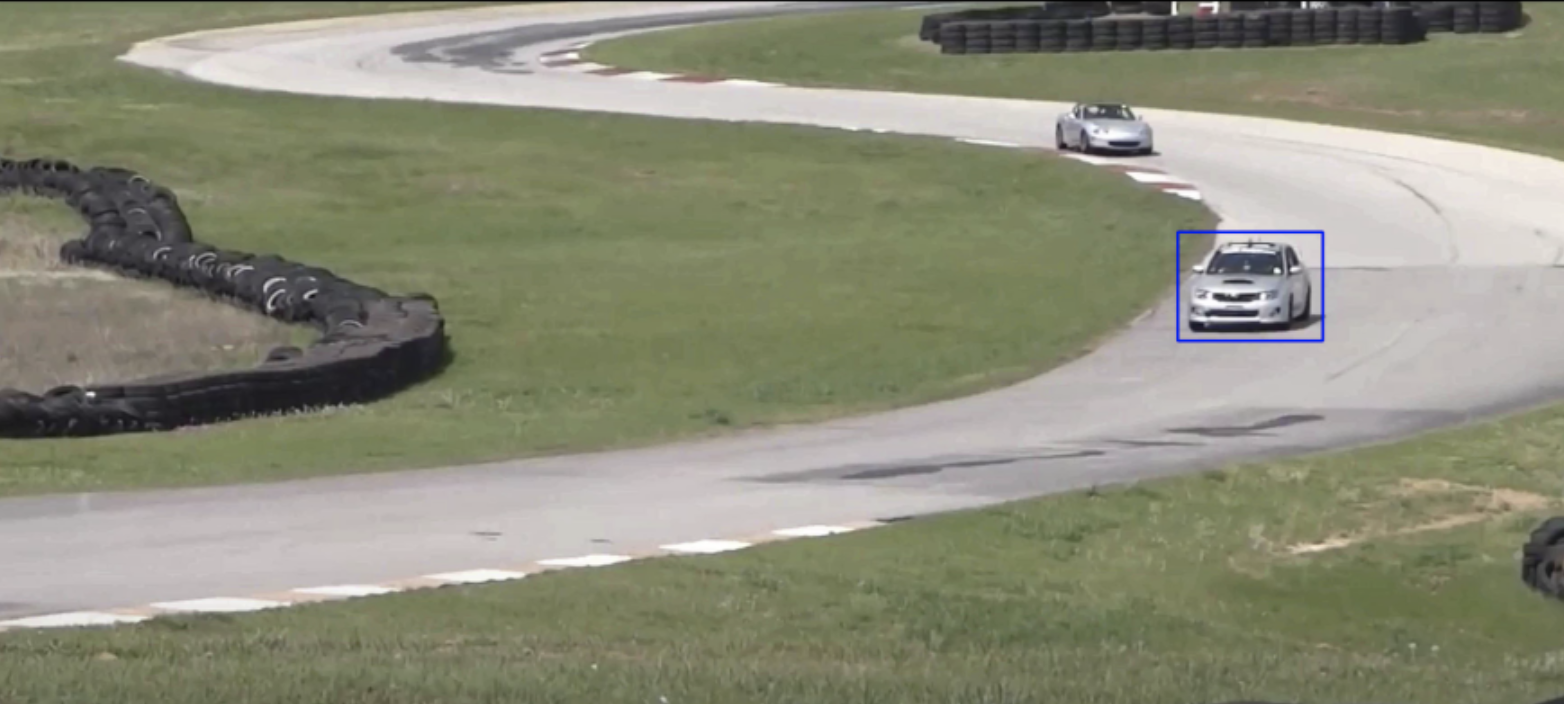

Here are soem necssary definitions and some helper functions

In [ ]:
# Import modules
import cv2
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import urllib

video_input_file_name = "./videos/race_car.mp4"

def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)

def displayRectangle(frame, bbox):
    plt.figure(figsize=(20,10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy); plt.axis('off')    

def drawText(frame, txt, location, color = (50,170,50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

### GOTURN pre-trained data  (download)

In [ ]:
if not os.path.isfile('./gparms/goturn.prototxt') or not os.path.isfile('.gparms/goturn.caffemodel'):
    print("Download GOTURN model zip file")
    # https://github.com/Mogball/goturn-files

### 1.  Create the Tracker instance to be used.

In [ ]:
# Set up tracker
tracker_types = ['BOOSTING', 'MIL','KCF', 'CSRT', 'TLD', 'MEDIANFLOW', 'GOTURN','MOSSE']

# Change the index to change the tracker type
tracker_type = tracker_types[2]

if tracker_type == 'BOOSTING':
    tracker = cv2.legacy_TrackerBoosting.create()
elif tracker_type == 'MIL':
    tracker = cv2.legacy.TrackerMIL_create()
elif tracker_type == 'KCF':
    tracker = cv2.legacy.TrackerKCF_create()
elif tracker_type == 'CSRT':
    tracker = cv2.legacy_TrackerCSRT.create()
elif tracker_type == 'TLD':
    tracker = cv2.legacy_TrackerTLD.create()
elif tracker_type == 'MEDIANFLOW':
    tracker = cv2.legacy_TrackerMedianFlow.create()
elif tracker_type == 'GOTURN':
    tracker = cv2.legacy.TrackerGOTURN_create()   
else:
    tracker = cv2.legacy_TrackerMOSSE.create()

###  Another DNN based Tracker

To use this, you must obtain the onnx backbone and head pre-trained parameters.
https://github.com/HonglinChu/SiamTrackers/tree/master/NanoTrack/models/nanotrackv2

In [ ]:
useNano=False
if useNano:
    params = cv2.TrackerNano_Params()
    params.backbone = 'nanotrack_backbone.onnx' 
    params.neckhead = 'nanotrack_head.onnx'
    tracker = cv2.TrackerNano_create(params)
    
    

##  2.  Read the video and (optionally) set output video

In [ ]:
# Read video
video = cv2.VideoCapture(video_input_file_name)
ok, frame = video.read()

# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
    sys.exit()
else : 
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
video_output_file_name = 'race_car-' + tracker_type + '.mp4'
video_out = cv2.VideoWriter(video_output_file_name,cv2.VideoWriter_fourcc(*'avc1'), 10, (width, height))

## 3. Define the bounding box

In [ ]:
# Define a bounding box
bbox = (1300, 405, 160, 120)
#bbox = cv2.selectROI(frame, False)
#print(bbox)
displayRectangle(frame,bbox)

## 4.  Initialize the Tracker

1. One Frame
2. A bounding box

In [ ]:
# Initialize tracker with first frame and bounding box

ok = tracker.init(frame, bbox)

## 5.  Read frame and Track object

In [ ]:
cv2.startWindowThread()
cv2.namedWindow("preview")

while True:
    ok, frame = video.read()
    if not ok:
        break 
    
    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);

    # Draw bounding box
    if ok:
        drawRectangle(frame, bbox)
    else :
        drawText(frame, "Tracking failure detected", (80,140), (0, 0, 255))

    # Display Info
    drawText(frame, tracker_type + " Tracker", (80,60))
    drawText(frame, "FPS : " + str(int(fps)), (80,100))
    
    # Write frame to video
    #video_out.write(frame)
    cv2.imshow('preview', frame)
     
    k = cv2.waitKey(30) & 0xff    #ESC  pressed
    if k == 27:
        break
    
video.release()
video_out.release()
cv2.destroyAllWindows()

## Suggested Exercises (not to be submitted)  To test you knowledge


1. Repeat the above for all the trackers in the list except GOTURN for the moment.  Uncomment the line that writes to a video output, so that you should produce a video for each.   


2. Uncomment the line where you can select your own bounding box. Try different sized boxes. What happens in each case. Experiment with different sized boxes in each case to see how it affects the output. 

3. Now implement GOTURN.  Use the same initialization  bounding box.   Compare the results with other trackers. 

4. **FIX** Select other videos and run the same tests. What happens?


# Multiple object Tracking

We saw that OpenCV has a naive multiple object tracker.  We will test this out. 

In [ ]:
#!/usr/bin/env python
from __future__ import print_function
import sys
import cv2
from random import randint


trackerTypes = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

def createTrackerByName(trackerType):
        # Create a tracker based on tracker name
        if trackerType == trackerTypes[0]:
            tracker = cv2.legacy.TrackerBoosting_create()
        elif trackerType == trackerTypes[1]:
            tracker = cv2.legacy.TrackerMIL_create()
        elif trackerType == trackerTypes[2]:
            tracker = cv2.legacy.TrackerKCF_create()
        elif trackerType == trackerTypes[3]:
            tracker = cv2.legacy.TrackerTLD_create()
        elif trackerType == trackerTypes[4]:
            tracker = cv2.legacy.TrackerMedianFlow_create()
        elif trackerType == trackerTypes[5]:
            tracker = cv2.legacy.TrackerGOTURN_create()
        elif trackerType == trackerTypes[6]:
            tracker = cv2.TrackerMOSSE_create()
        elif trackerType == trackerTypes[7]:
            tracker = cv2.legacy.TrackerCSRT_create()
        else:
            tracker = None
            print('Incorrect tracker name')
            print('Available trackers are:')
            for t in trackerTypes:
                print(t)

        return tracker

# Set video to load
videoPath = "run.mp4"
#videoPath = "race_car.mp4"

# Create a video capture object to read videos
cap = cv2.VideoCapture(videoPath)

# Read first frame
success, frame = cap.read()
# quit if unable to read the video file
if not success:
  print('Failed to read video')
  sys.exit(1)

  ## Select boxes
bboxes = []
colors = [] 

# OpenCV's selectROI function doesn't work for selecting multiple objects in Python
# So we will call this function in a loop till we are done selecting all objects
while True:
  # draw bounding boxes over objects
  # selectROI's default behaviour is to draw box starting from the center
  # when fromCenter is set to false, you can draw box starting from top left corner
  bbox = cv2.selectROI('MultiTracker', frame)
  bboxes.append(bbox)
  colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))
  print("Press q to quit selecting boxes and start tracking")
  print("Press any other key to select next object")
  k = cv2.waitKey(0) & 0xFF
  print(k)
  if (k == 113):  # q is pressed
    break

print('Selected bounding boxes {}'.format(bboxes))

# Specify the tracker type
trackerType = "CSRT"
createTrackerByName(trackerType)

# Create MultiTracker object
multiTracker = cv2.legacy.MultiTracker_create()


# Initialize MultiTracker 
for bbox in bboxes:
  multiTracker.add(createTrackerByName(trackerType), frame, bbox)


  # Process video and track objects
while cap.isOpened():
  success, frame = cap.read()
  if not success:
    break
  
  # get updated location of objects in subsequent frames
  success, boxes = multiTracker.update(frame)

  # draw tracked objects
  for i, newbox in enumerate(boxes):
    p1 = (int(newbox[0]), int(newbox[1]))
    p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
    cv2.rectangle(frame, p1, p2, colors[i], 2, 1)

  # show frame
  cv2.imshow('MultiTracker', frame)
  

  # quit on ESC button
  if cv2.waitKey(1) & 0xFF == 27:  # Esc pressed
    break

    
    
cv2.destroyAllWindows()